## 04 Production  
This notebook highlights my most accurate classification model plus the model that best differentiates words common to r/Playstation.  

#### Skip Ahead:  
[Model 13](#Model-13)  
[Model 14](#Model-14)  
[Conclusion](#Conclusion)

In [8]:
#imports
#common code:
from scipy.stats import ttest_ind
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import re
#week 3
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
#week 4
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
#week 5
import requests
from bs4 import BeautifulSoup
import time
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

In [9]:
df = pd.read_csv('../sub_data/clean_subs.csv')

In [10]:
#df.head() #preview

In [11]:
X = df['all_text']
y = df['subreddit']

In [12]:
y.value_counts(normalize=True)

1    0.50237
0    0.49763
Name: subreddit, dtype: float64

In [13]:
#split data
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=17)

### Model 13

This is a Logistic Regression classification model using the best parameters as identified by my gridsearch in the "Modeling" notebook.

The cross val score is: 0.9219950804414306
The best training score was: 0.9749949038526874
The test score is: 0.9219323277619241


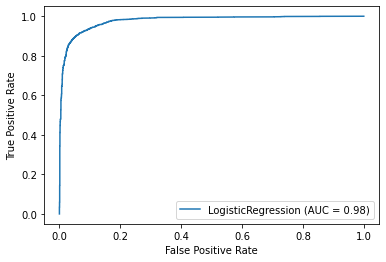

In [25]:
cvec = CountVectorizer(max_features=20_000,
                       min_df=4, 
                       max_df = .4,
                       ngram_range=(1,2),
                       stop_words=stopwords.words('english'))
X_train_c = cvec.fit_transform(X_train)
X_test_c = cvec.transform(X_test)
#only use best hyperparameters that above grid search preferred
logreg = LogisticRegression(C=.1,
                           max_iter = 1000,
                           solver='liblinear')

logreg.fit(X_train_c, y_train)


print(f'The cross val score is: {cross_val_score(logreg, X_train_c, y_train).mean()}')
print(f'The best training score was: {logreg.score(X_train_c, y_train)}')
print(f'The test score is: {logreg.score(X_test_c, y_test)}')
metrics.plot_roc_curve(logreg, X_test_c, y_test);
#plt.savefig('../images/best_roc.png', dpi=200, bbox_inches='tight');

There we go - the cross-val score on the training set is extremely close to the test score, suggesting that we have not only a good fit but a model that can generalize well on unseen data. We also see a good AUC score on the ROC curve.

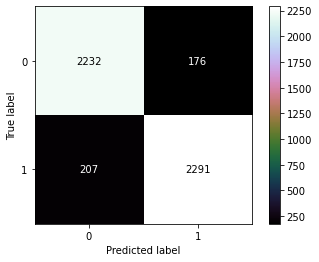

The Accurracy score is 0.9219323277619241
The Sensitivity score is 0.9171337069655725
The Precision score is 0.9286582894203486


In [26]:
preds = logreg.predict(X_test_c)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

plot_confusion_matrix(logreg, X_test_c, y_test, cmap='cubehelix', values_format='d');
#plt.savefig('../images/best_conf.png', dpi=200, bbox_inches='tight')
plt.show()
print(f'The Accurracy score is {metrics.accuracy_score(y_test, preds)}')
print(f'The Sensitivity score is {metrics.recall_score(y_test, preds)}')
print(f'The Precision score is {metrics.precision_score(y_test, preds)}')

In [16]:
print(f'The F1 score is {metrics.f1_score(y_test, preds)}')

The F1 score is 0.9228600201409869


This is a better F1 score than my best Naive Bayes or Random Forest models!

In [17]:
lr_coef_df = pd.DataFrame(logreg.coef_, #exponentiate coefficients from logistic regression
                          columns = cvec.get_feature_names())
lr_coef_df.rename(index={0:'coef'}, inplace=True)
lr_coef_df = lr_coef_df.T #rotate dataframe
lr_coef_df['exp_coefs'] = np.exp(lr_coef_df['coef'])
lr_coef_df['coef_abs'] = lr_coef_df['coef'].abs()
lr_coef_df.sort_values(by='coef_abs', ascending=False).head(10)
#print(lr_coef_df.sort_values(by='coef_abs', ascending=False).head(10).to_markdown())

,coef,exp_coefs,coef_abs
playstation,2.642689,14.050938,2.642689
ps5,2.477325,11.909364,2.477325
ps4,2.125546,8.377472,2.125546
xbox,-2.036876,0.130436,2.036876
ps,1.885038,6.586607,1.885038
psn,1.694283,5.442743,1.694283
sony,1.466438,4.333770,1.466438
series,-1.433064,0.238577,1.433064
ps3,1.196478,3.308445,1.196478
dualshock,1.002451,2.724953,1.002451


This table shows the coefficients sort by the largest (absolute value). For comparision, it also shows the exponentiated coefficients since we used Logistic Regression. We can see that the words we expect to indicate playstation naturally have the largest values, while similarly the words we would associate with Xbox have the smallest values.

### Model 14  
For this last model, I am going to attempt to remove as many unique "Xbox" and "Playstation" words as possible by appending them to my stop words list. While this is very unlikely to improve my overall accuracy, it should give a better picture of what different language choices authors in the two subreddits make outside of console-specific terminology.

In [18]:
#https://stackoverflow.com/questions/5511708/adding-words-to-nltk-stoplist
#appending unique terminology to stop words list
sword_list = set(stopwords.words('english'))
sword_list.update(['playstation', 'ps5', 'ps4', 'ps3', 'ps', 'psn', 'sony', 'xbox', 'series', 'dualshock',
                  'plus', 'ps2', 'slim', 'gamepass', 'microsoft', 'gamertage', 'pro',
                  '360', 'elite', 'gamertag', 'ps1', 'ultimate', 'gold', 'halo', 'xsx', 'one',
                  'live', 'xcloud', 'trophies', 'trophy', 'ds4', 'ms', 'psnow', 'psvr', 'kinect',
                   'vita', 'primary', 'bloodborne', 'ghost', 'infinite', 'forza',
                  'achievements', 'gears', 'updating', 'library', 'id', 'psp', 'og', 'batteries',
                  'playstations', 'tsushima', 'platinum', 'ps4s'])

In [19]:

cvec = CountVectorizer(max_features=20_000,
                       min_df=4, 
                       max_df = .4,
                       ngram_range=(1,2),
                       stop_words=sword_list)
X_train_c = cvec.fit_transform(X_train)
X_test_c = cvec.transform(X_test)
#only use best hyperparameters that above grid search preferred
logreg = LogisticRegression(C=.1,
                           max_iter = 1000,
                           solver='liblinear')

logreg.fit(X_train_c, y_train)

print(f'The best training score was: {logreg.score(X_train_c, y_train)}')
print(f'The test score is: {logreg.score(X_test_c, y_test)}')

The best training score was: 0.8857104029353808
The test score is: 0.7128006522625356


In [20]:
lr_coef_df = pd.DataFrame(logreg.coef_, #exponentiate coefficients from logistic regression
                          columns = cvec.get_feature_names())
lr_coef_df.rename(index={0:'coef'}, inplace=True)
lr_coef_df = lr_coef_df.T #rotate dataframe
lr_coef_df['exp_coefs'] = np.exp(lr_coef_df['coef'])
lr_coef_df['coef_abs'] = lr_coef_df['coef'].abs()
lr_coef_df.sort_values(by='coef', ascending=False).head(10)

,coef,exp_coefs,coef_abs
last us,0.891795,2.439504,0.891795
remote play,0.874625,2.397975,0.874625
banned,0.694134,2.001975,0.694134
hacked,0.681458,1.976757,0.681458
fall guys,0.670572,1.955355,0.670572
wallet,0.665569,1.945598,0.665569
safe mode,0.654261,1.923720,0.654261
database,0.614393,1.848534,0.614393
3d,0.585130,1.795224,0.585130
network,0.582289,1.790132,0.582289


After extensively removing unique identifying words from the model, here are the 10 strongest postitive coefficients meaning they are most indicative of our "1" which is r/playstation. If I were to generally categorize these words, I would group them as:  
- Playstation exclusive games like Last (of) Us, Fall Guys (others were added to the stop word list to dig deeper)
- Account/security concerns i.e. banned, hacked, wallet, safe mode, network
- Highly anticipated features i.e. remote play and 3d

### Conclusion

Based on my analysis, I would recommend that any marketing efforts aimed at winning over former playstation users focus on Microsoft's answers to these concerns. Specifically, marketing referring to upcoming special Xbox-only games, ease of use and/or security of the Xbox account and online systems, and cutting edge advancements in online and remote play.